In [1]:
__author__ = 'Aida Wofford and LVM team'
__version__ = '20250501'
__datasets__ = ['SDSS-V LVM SFrame (DRPVER=1.1.1, MJD=60191, EXPNUM=4297)']  
__keywords__ = ['Helix nebula']

# SDSS-V LVM DR19 "Helix nebula" tutorial
<img src='helix_mjd60191_expnum4297.png' />

<p style="line-height: 1.5;"><b>Figure. </b>Digital Sky Survey image of the Helix nebula. We overlay the footprints of LVM's field of view and fibers. We highlight the central fiber in orange.</p>

# Purpose
This tutorial focuses on data from LVM's science telescope. It teaches to:
<ol>
  <li>Find the coordinates (RA [deg] & DEC [deg]) of fibers that are free of problems</li>
  <li>Make a map of the fibers with fibers labelled with their id</li>
  <li>Extract and plot the reduced spectrum of a fiber of given id</li>
  <li>Make an emission map based on the extraction of a spectral window, e.g., around an emission line</li>
  <li>Make an RGB map that combines fluxes from three different spectral windows that capture emission lines</li>
  <li>Fit a Gaussian to an emission line to obtain its flux</li>
  <li><span style="color:red">Make a flux ratio map based on Gaussian fits to lines.</span></li>
</ol> 

# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from astropy.io import fits
import os
import glob
from astropy.table import Table
from scipy.optimize import curve_fit

# Functions

In [3]:
def build_path_to_data(path_to_data_dir, expnum):
    '''
    purpose
        Build path to data
    inputs
        path_to_data_dir: string, directory with the lvmSFrame-00004297.fits file, which contains the data
        expnum: integer, exposure number
    outputs
        path_to_data_file: string, complete path to fits file
    '''
    
    # A fiel with reduced data is associated to what we call a science frame or SFrame
    # Set the base name of the fits file associated with the SFrame
    basename = 'lvmSFrame-NAME.fits' 

    # Find filenames in the data directory with the basename structure and the exposure number
    # This is mostly useful if your directory contains files from multiple LVM exposures...
    matches = glob.glob(path_to_data_dir + '/**/' + basename.replace('NAME', f'{expnum:08}'), recursive=True)

    # Message the user with the results from the file search
    if matches:
        path_to_data_file = matches[0]
        print(f"File: \'{path_to_data_file}\' exists.")
    else:
        print("File not found.")
        path_to_data_file = None  
        
    return path_to_data_file

def get_good_data(path_to_data_file):
    '''
    purpose
        Obtain data for fibers without problems
    inputs
        path_to_data_file: string, complete path to fits file
    outputs
        fibermap: table with fibermap (all fibers)
        wave: NumPy array with wavelengths (Angstrom units, includes gaps due to bad columns)
        flux: 2D NumPy array with flux arrays for each good fiber (erg/s/cm2/A, fluxes for bad columns are set to NaN)
        error: 2D NumPy array with flux errors (standard deviations) for each good fiber 
        df: filtered data frame excluding data for the bad fibers (erg/s/cm2/A)
    '''
    
    # Open data file and load data (including bad fibers) into a "Header Data Unit List object" called sframe
    sframe = fits.open(path_to_data_file)

    # Store fibermap table into variable fibermap
    fibermap = Table(sframe['SLITMAP'].data)

    # For the science telescope, find indices of fibers without problems
    indices_good_scitel_fibers = (fibermap['targettype']=='science') & (fibermap['fibstatus'] == 0)

    # Load the wavelengths into variable wave
    wave = sframe['WAVE'].data

    # Load the flux arrays of good fibers in variable flux
    flux = sframe['FLUX'].data[indices_good_scitel_fibers]

    # Load the inverse variace of good fibers in variable ivar
    # The variance is the square of the standard deviation
    # The flux errors are equal to the standard deviation and thus = 1/sqrt(ivar)
    ivar = sframe['IVAR'].data[indices_good_scitel_fibers]
    error = 1/np.sqrt(ivar)

    # Close sframe object
    sframe.close()

    # Create a data frame with the content of the good fibers
    df = fibermap[indices_good_scitel_fibers].to_pandas()
    
    return fibermap, wave, flux, error, df


def get_flux_index(fiber, df):
    '''
    purpose
        Obtain index to retreive flux array of given fiber
    inputs
        fiber: integer, fiber number
        df: data frame, contains data for the good fibers
    outpus
        flux_index: integer, flux index
    '''
    
    for i in range(len(df)):
        if df["fiberid"][i] == fiber:
            flux_index = i
            
    return flux_index

def hexagonal_plots(fig_width, fig_height, fontsize, tick_label_size, marker_size, marker_width,
                    sym, facecolors, edgecolors,
                    xlabel, ylabel):
    '''
    purpose
        Plot fiber map where the axes are the RA [deg] and Dec [deg] and the RA decreases from left to right
    inputs
        fig_width, fig_height, fontsize, tick_label_size, marker_size, marker_width: scalars
        sym, facecolors, edgecolors: strings
        xlabel, ylabel: strings
        df: data frame, contains data for the good fibers
    outpus
        ax: single subplot
    '''
    
    # Set plot parameters
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))   

    # Set axis labels with controlled fontsize
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)

    # Set tick labels font size
    ax.tick_params(axis='both', which='major', labelsize=tick_label_size)  # 'both' means x and y

    # Use the filtered data frame to create the plot
    ax.scatter(
        df["ra"],
        df["dec"], 
        marker=sym,
        facecolors=facecolors,         # No fill inside the marker
        edgecolors=edgecolors,          # Gray border
        s=marker_size,                     # Size of markers 
        linewidths=marker_width)             # Thickness of the border

    # Invert x-axis
    ax.invert_xaxis()

    # Automatically adjust the spacing of subplots
    fig.tight_layout()
    
    return ax

def plot_single_fiber_sp_win(wavelengths, fib_fluxes, fib_errors, minwave, maxwave, emission_lines):
    '''
    inputs: 
        wavelengths: NumPy array, wavelengths
        fib_fluxes: NumPy array, fluxes for given fiber
        fib_errors: NumPy array, flux errors for given fiber
        minwave, maxwave: scalars, minimum and maximum wavelengths to be plotted
        lines: list of scalars, rest-frame air wavelengths of lines of interest
    outputs:
        plot
    '''
    
    # Set plot parameters
    fig, ax = plt.subplots(figsize = (6, 3))
    plt.rcParams['font.size'] = 10 
    
    # Plot
    plt.plot(wavelengths, fib_fluxes, zorder=10, label='Flux')
    plt.plot(wavelengths, fib_errors, zorder=11, label='Flux error')
    plt.title(f'Helix nebula, fiber #{fiber}')
    plt.xlabel(r'Observed wavelength [${\rm \AA}$]')
    plt.ylabel(r'Flux [ergs / s / cm$^2$ / ${\rm \AA}$ / fiber]')
    plt.legend()
    plt.grid(alpha = 0.3)
    
    # Set x-axis range
    plt.xlim(minwave, maxwave)   
    
    # Set y-axis range
    mask = (wavelengths >= minwave) & (wavelengths <= maxwave)
    ymax = max(fib_fluxes[mask])
    plt.ylim(0, 1.1*ymax)

    for label, wl in emission_lines.items():
        # Add vertical-dashed lines at the rest-frame air wavelengths of the emisison lines of interest
        plt.axvline(wl, color='gray', linestyle='--', zorder=0)
        
        # Label emission lines
        plt.text(wl, ymax * 0.95, label, rotation=90, color='black', verticalalignment='top')

        # Shade area between vertical lines, 5 Ang away from each line of interest
        plt.axvspan(wl - 5, wl + 5, color='lightgray', alpha=0.3)

    return

def lvm_emission_line_map(lines):
    '''
    purpose
        Make a 3-panel plot where each panel shows the emission map of a different emission line
        Spectral windows around the lines rather than Gaussian fits to the lines are used
        The plots include the continuum emission and are not corrected for stellar absorption, background contamination, or reddening
    inputs
        lines: dictionary (string, (scalar, scalar)) or 
        (ename, (ewave, ewidth)) <=> (ion, (air rest-frame wavelength, window half-width))
    '''
    
    ncols = 3
    nrows = 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols,8), sharex=True, sharey=True)#, layout="constrained", subplot_kw=dict(projection=wcs))
    fig.suptitle(f"Helix nebula")
    plt.gca().invert_xaxis() # plt.gca gets the current axis object, .invert_xaxis inverts the x-axis so that RA increases right to left
    axs = axs.flatten()
    
    for i, (ename, (ewave, ewidth)) in enumerate(lines.items()):
        # Make mask for spectral window of interest
        mask = (ewave-ewidth <= wave)&(wave <= ewave+ewidth)

        # Load masked flux 2D array in variable z
        z = np.nanmean(flux[:, mask], axis=1) # all good fibers are included

        # A sqrt stretch is used
        norm = simple_norm(z, stretch="sqrt", min_percent=1, max_percent=99)

        # Plot title
        axs[i].set_title(f"{ename} {int(ewave)}")

        # Define color maps
        cmap_color=["Blues", "Greens", "Reds"]
        
        # Plot
        img = axs[i].scatter(x, y, s=65, lw=0, c=z, marker='o', cmap=cmap_color[i], norm=norm, edgecolors='none')
        
        # Add a colorbar with a different colormap for each image
        cbar = fig.colorbar(img, ax=axs[i], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label(r'Flux [ergs / s / cm$^2$ / ${\rm \AA}$ / fiber]')

        # Call the function to obtain the flux index for a fiber contaminated with a star
        star_fiber = 519
        index_star_fiber = get_flux_index(star_fiber, df)

        #Highlight fiber contaminated with bright star in magenta
        axs[i].scatter(
            df["ra"][index_star_fiber],
            df["dec"][index_star_fiber], 
            marker="o",
            facecolors='none',         # No fill inside the marker
            edgecolors='magenta',      # magenta border
            s=65,                      # Size of markers
            linewidths=1.5)            # Width of marker's border
        
    fig.supxlabel("RA (deg)")
    fig.supylabel("Dec (deg)")
 
    plt.tight_layout()

# Set the font size for the plot
plt.rcParams['font.size'] = 10


# Function to create an RGB map using spectral windows that capture 3 given lines
def rgb_map(lines):
    '''
    inputs:
        lines: dictionary (string, (scalar, scalar)) or 
        (ename, (ewave, ewidth)) <=> (ion, (air rest-frame wavelength, window half-width))
    outputs:
        rgb map
    '''

    for i, (ename, (ewave, ewidth)) in enumerate(lines.items()):

        mask = (ewave-ewidth <= wave)&(wave <= ewave+ewidth)
        if i == 0:
            # list of fluxes for each fiber in the window of the first line
            b_flux = np.nanmean(flux[:, mask], axis=1) 
        elif i == 1:
            # list of fluxes for each fiber in the window of the second line
            g_flux = np.nanmean(flux[:, mask], axis=1)
        else:
            # list of fluxes for each fiber in the window of the third line
            r_flux = np.nanmean(flux[:, mask], axis=1)


    # For each of the three spectral lines, ignore the 1% of the fibers with the faintest fluxes and the 1% of the fibers with the brightest fluxes.
    # There are 1754 good fibers and 1% of this number is 18 fibers.
    # Record the flux of the 19th faintest and 19th brightest fibers.
    min_r_flux = np.sort(r_flux)[18] 
    max_r_flux = np.sort(r_flux)[-18] 
    min_g_flux = np.sort(g_flux)[18] 
    max_g_flux = np.sort(g_flux)[-18] 
    min_b_flux = np.sort(b_flux)[18] 
    max_b_flux = np.sort(b_flux)[-18] 

    # Re-map flux range to values between 0 and 1 and and clip the fluxes of fibers that we are ignoring.
    # Values below min_flux are set to 0.
    # Values above max_flux are set to 1.
    # Values in between are mapped linearly onto the interval 0 to 1.
    r_norm = np.clip((r_flux - min_r_flux) / (max_r_flux - min_r_flux), 0, 1)
    g_norm = np.clip((g_flux - min_g_flux) / (max_g_flux - min_g_flux), 0, 1)
    b_norm = np.clip((b_flux - min_b_flux) / (max_b_flux - min_b_flux), 0, 1)

    # Apply a sqrt strech to the flux range
    # this makes faint signals more prominent
    r_norm = np.sqrt(r_norm)
    g_norm = np.sqrt(g_norm)
    b_norm = np.sqrt(b_norm)

    # Apply a sqrt strech a second time
    # this makes faint signals even more prominent
    #r_norm = np.sqrt(r_norm)
    #g_norm = np.sqrt(g_norm)
    #b_norm = np.sqrt(b_norm)

    # Combine into an (N, 3) color array
    colors = np.stack([r_norm, g_norm, b_norm], axis=1)

    # Set plot parameters and plot
    plt.figure(figsize=(6, 6))
    plt.title('Helix nebula\n'+r'R = [S II] 6717, G = H$\alpha$ 6563, B = [O III] 5007')
    for ifiber in range(len(b_flux)):
        plt.scatter(x[ifiber], y[ifiber], color=colors[ifiber], s=45, edgecolors='none')
    plt.gca().invert_xaxis() # plt.gca gets the current axis object, .invert_xaxis inverts the x-axis so that RA increases right to left
    plt.xlabel("RA (deg)")
    plt.ylabel("Dec (deg)")
    plt.axis('equal')

    # Call the function to obtain the flux index for a fiber contaminated with a star
    star_fiber = 519
    index_star_fiber = get_flux_index(star_fiber, df)
    
    # Highlight fiber with star in magenta
    plt.scatter(
        df["ra"][index_star_fiber],
        df["dec"][index_star_fiber], 
        marker="o",
        facecolors='none',        # No fill inside the marker
        edgecolors='magenta',     # magenta border
        s=45,                     # Size of markers
        linewidths=1.5)

    plt.show()

    return

def gaussian(x, amplitude, mean, sigma):
    '''
    purpose
        Evaluate an unormalized Gaussian function (area under curve = amplitude*sigma*sqrt(2*pi) at input value
    inputs
        x: input value(s), can be a scalar or NumPy array
        amplitude: scalar, height of the peak
        mean: scalar, center of the peak
        sigma: scalar, standard deviation
    outpus
        Gaussian function evaluated at input values
    '''
    return amplitude * np.exp(-((x - mean)**2) / (2 * sigma**2))


def single_gaussian_line_flux(wavelengths, fluxes, minwave, maxwave, x0, exclude_regions):
    '''
    purpose
        Find emission line flux by:
        - Subracting the continuum, 
        - Fitting a single unormalized Gaussian to the emission line, and
        - Finding the area under Gaussian = amplitude*sigma*sqrt(2*pi)
    inputs
        wavelengths: NumPy array of scalar values, wavelength values
        fluxes: NumPy array of scalar values, fluxes at each wavelength (note: flux=Nan for bad columns, i.e. regions with wavelength gaps)
        minwave, maxwave: scalars, wavelength limits for spectral window containing emission line to be measured
        x0: scalar, estimated wavelength of the line center
        exclude_regions: array or 2D array, wavelength ranges within spetral window to exclude when fitting the continuum
    outpus
        line_flux: emission line flux
    '''
    
    # Create a mask to extract wavelength range of interest
    subarr_mask = (wavelengths >= minwave) & (wavelengths <= maxwave)

    # Use mask to extract wavelength and flux subarrays of interest
    subarr_wave = wavelengths[subarr_mask]
    subarr_flux = fluxes[subarr_mask]
    
    # Define spectral windows to exclude

    # Create a continuum mask with all data included
    cont_mask = np.ones_like(wavelengths, dtype=bool)

    # Exclude each line region from the mask
    for start, end in exclude_regions:
        # Update cont_mask (&=) with wavelengths that do not satisfy the condition (~)
        cont_mask &= ~((wavelengths >= start) & (wavelengths <= end))  
    
    # Apply continuum mask
    xcont = wavelengths[cont_mask]
    ycont = fluxes[cont_mask]

    #Fit a line to the nearby continuum
    fit_coeffs = np.polyfit(xcont, ycont, deg=1)
    fit_line = np.polyval(fit_coeffs, subarr_wave)

    # Subtract continuum
    cont_sub_flux = subarr_flux - fit_line

    # Initial parameter guess: (amplitude, mean, sigma)
    p0 = [np.max(cont_sub_flux), x0, 1]
    try:
        # Fit the curve
        params, _ = curve_fit(gaussian, subarr_wave, cont_sub_flux, p0=p0)
        
        # Evaluate fitted Gaussian
        fit_y = gaussian(subarr_wave, *params)
        line_flux = np.sqrt(2*np.pi)*params[2]*params[0]
    except:
        line_flux = np.nan
        
    return line_flux

def lvm_line_ratio_map(wave, flux, df):
    '''
    purpose
        Uses Balmer line fluxes from Gaussian fitting of continuum subtracted spectra
        No stellar absorption or background subtraction are applied
        Creates Ha/Hb line flux ratio map
        Only values between 2 and 3 are included in the color map
        Values below 2.8 are not physical and can be due to 
        - fiber captures bright star
        - stellar absorption under Hβ,
        - low signal-to-noise,
        - background contamination
    inputs
        wave, NumPy array, wavelengths
        flux, NumPy 2D arry, fluxes for each good fiber
        df: filtered data frame with good fibers
    outputs
        line ratio map
    '''
    
    # Set plot parameters
    fig, ax = plt.subplots(figsize=(12, 12))   

    # Set axis labels with controlled fontsize
    ax.set_xlabel('RA [deg]', fontsize=10)
    ax.set_ylabel('DEC [deg]', fontsize=10)

    # Set tick labels font size
    ax.tick_params(axis='both', which='major', labelsize=10)  # 'both' means x and y

    # Initialize arrays
    flux_ratio = []
    x = []
    y = []
    eraseme=[] # for unphysical line ratios

    x = df['ra']
    y = df['dec']
    
    for i in range(len(df)):
        #x = np.append(x,df['ra'][i])
        #y = np.append(y,df['dec'][i])

        # Initialize values
        fha, fhb = -1, -1
        
        # For a given fiber, get wavelengths and fluxes
        wavelengths = wave
        flux_index = get_flux_index(df["fiberid"][i], df)
        fluxes = flux[flux_index] 

        # Remove nan values from wavelength and flux arrays
        not_nan_indices = np.where(~np.isnan(fluxes))[0]
        wavelengths = wavelengths[not_nan_indices]
        fluxes = fluxes[not_nan_indices]

        # Variable in Ang
        dx=5
        
        # Find Hb flux
        minwave, maxwave, x0 = 4830, 4900, 4861.325
        exclude_regions = [(4861.325-dx, 4861.325+dx)] # region(s) to be excluded from fit to continuum
        fhb = single_gaussian_line_flux(wavelengths, fluxes, minwave, maxwave, x0, exclude_regions)

        # Find Ha flux
        minwave, maxwave, x0 = 6520, 6600, 6562.80
        exclude_regions = [(6548.04-dx, 6548.04+dx),(6562.80-dx, 6562.80+dx),(6583.46-dx, 6583.46+dx)] # region(s) to be excluded from fit to continuum
        fha = single_gaussian_line_flux(wavelengths, fluxes, minwave, maxwave, x0, exclude_regions)

        # Filter fluxes, realistic ones are >= 2.8
        # We include fluxes from 2-2.8 to compare with Rogelio's figure
        if ((fha != np.nan) & (fhb != np.nan) & (fha / fhb > 2) & (fha / fhb <= 3)):
            flux_ratio = np.append(flux_ratio, fha / fhb)
        else:
            flux_ratio = np.append(flux_ratio, 2)
            eraseme = np.append(eraseme,i)

    img = plt.scatter(x, y, s=125, lw=0, c=flux_ratio, marker='o', cmap="viridis", edgecolors='none', vmin=2, vmax=3)
    
    erasex = [x[int(i)] for i in eraseme]
    erasey = [y[int(i)] for i in eraseme]
    
    plt.scatter(erasex, erasey, s=125, lw=0, facecolor='black', marker='o', edgecolors='none')
    
    # Add a colorbar for each image
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label(r'H$\alpha$/H$\beta$')

    #Highlight a fiber with a star in magenta
    # Call the function to obtain the flux index for the fiber of interest
    index_519 = get_flux_index(519, df)
    ax.scatter(
        df["ra"][index_519],
        df["dec"][index_519], 
        marker="o",
        facecolors='none',         # No fill inside the marker
        edgecolors='magenta',          # orange border
        s=125,                     # Size of markers
        linewidths=2)
    ax.invert_xaxis()
    return

# Path to data file, exposure number, and fits file info

In [4]:
# In this example, we set the path to the data directory to os.getcwd(), which is the current working directory
path_to_data_dir = os.getcwd() 

# Exposure number of the data
expnum = 4297 

# Get path to data file
path_to_data_file = build_path_to_data(path_to_data_dir, expnum)

# Open the file at the location 'path_to_data_file' and print a summary of the Header Data Units
fits.info(path_to_data_file)

File: '/Users/aidawofford/Mi/Investigacion/LVM/Python/lvmSFrame-00004297.fits' exists.
Filename: /Users/aidawofford/Mi/Investigacion/LVM/Python/lvmSFrame-00004297.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     898   ()      
  1  FLUX          1 ImageHDU        20   (12401, 1944)   float32   
  2  IVAR          1 ImageHDU        20   (12401, 1944)   float32   
  3  MASK          1 ImageHDU        19   (12401, 1944)   uint8   
  4  WAVE          1 ImageHDU        19   (12401,)   float32   
  5  LSF           1 ImageHDU        20   (12401, 1944)   float32   
  6  SKY           1 ImageHDU        20   (12401, 1944)   float32   
  7  SKY_IVAR      1 ImageHDU        20   (12401, 1944)   float32   
  8  SLITMAP       1 BinTableHDU     58   1944R x 21C   [K, K, 3A, K, 8A, 5A, K, 4A, D, D, K, 6A, 8A, K, 17A, D, K, K, K, D, D]   


# Display contents of fibermap table

In [5]:
# For the science telescope, get data for fibers without problems
fibermap, wave, flux, error, df = get_good_data(path_to_data_file)
Table(fibermap)

fiberid,spectrographid,blockid,finblock,targettype,ifulabel,finifu,telescope,xpmm,ypmm,ringnum,orig_ifulabel,orig_slitlabel,finsector,fmap,ypix_b,ypix_r,ypix_z,fibstatus,ra,dec
int64,int64,str3,int64,str8,str5,int64,str4,float64,float64,int64,str6,str8,int64,str17,float64,int64,int64,int64,float64,float64
1,1,B1,1,SKY,SkyW3,1,SkyW,0.0,0.0,1,A3-1,S1B1-1,1,SkyW3-1:S1B1-1,4004.0,4015,4012,0,321.613,-44.54320000000001
2,1,B1,2,standard,Spec1,135,Spec,1.429,5.115,19,P1-1,S1B1-2,1,Spec1-1:S1B1-2,3998.0,4010,4007,0,0.04460363918612728,-0.1596550041287928
3,1,B1,3,science,Sci1,1,Sci,0.0,7.92,25,S1-1,S1B1-3,1,Sci1-1:S1B1-3,3993.0,4004,4001,0,337.4169474614286,-21.084344018449997
4,1,B1,4,science,Sci1,2,Sci,0.286,7.755,25,S1-2,S1B1-4,2,Sci1-2:S1B1-4,3987.0,3999,3995,0,337.42638153117906,-21.07898431939437
5,1,B1,5,science,Sci1,3,Sci,0.572,7.59,25,S1-3,S1B1-5,3,Sci1-3:S1B1-5,3981.0,3993,3990,0,337.43581492731073,-21.073624095271583
6,1,B1,6,science,Sci1,4,Sci,0.857,7.425,25,S1-4,S1B1-6,4,Sci1-4:S1B1-6,3976.0,3987,3984,0,337.4452142099591,-21.068264089182854
7,1,B1,7,science,Sci1,5,Sci,1.143,7.26,25,S1-5,S1B1-7,5,Sci1-5:S1B1-7,3970.0,3982,3978,0,337.45464625878174,-21.062902818356775
8,1,B1,8,science,Sci1,6,Sci,1.429,7.095,25,S1-6,S1B1-8,6,Sci1-6:S1B1-8,3965.0,3976,3973,0,337.46407763267024,-21.05754102404877
9,1,B1,9,science,Sci1,7,Sci,1.715,6.93,25,S1-7,S1B1-9,7,Sci1-7:S1B1-9,3959.0,3971,3967,0,337.47350833118605,-21.0521787067879


# For the science telescope, get data for fibers without problems

In [6]:
fibermap, wave, flux, error, df = get_good_data(path_to_data_file)

# Make fiber map with fiber-id labels and central fiber highlighted

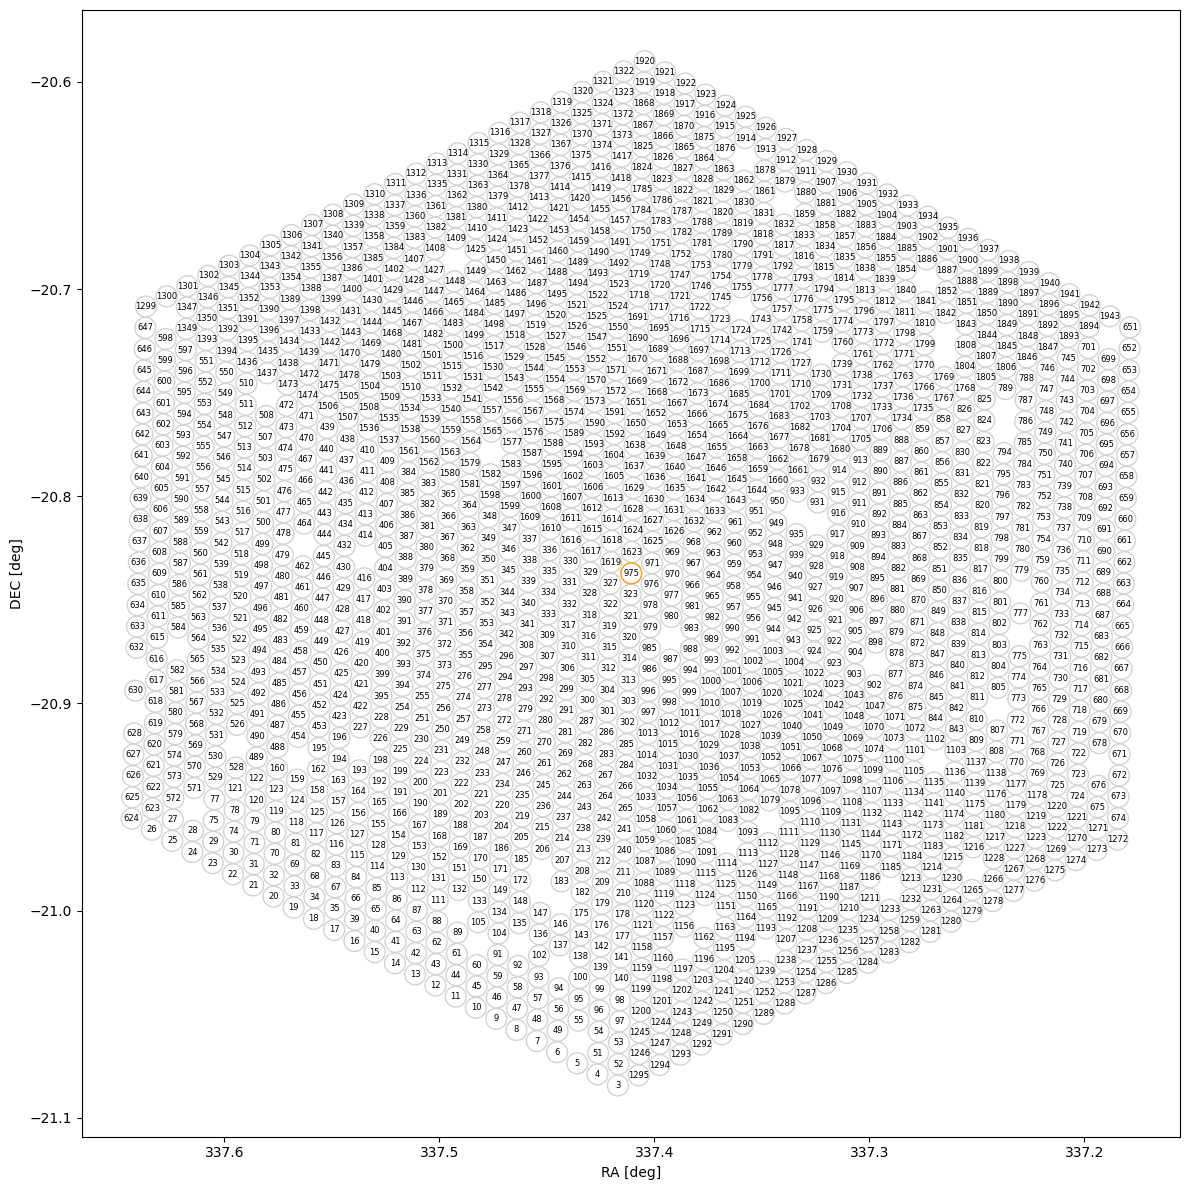

In [7]:
# Give the input values for the plot
fig_width, fig_height, fontsize, tick_label_size, marker_size, marker_width = 12, 12, 10 ,10, 225, 1
sym, facecolors, edgecolors = "o", "none", "lightgray"
xlabel, ylabel = 'RA [deg]', 'DEC [deg]'

# Plot good fiber map
ax = hexagonal_plots(fig_width, fig_height, fontsize, tick_label_size, marker_size, marker_width,
                     sym, facecolors, edgecolors,
                     xlabel, ylabel)

# Pick id of fiber of interest
fiber = 975

# Call function to obtain flux index of fiber of interest
flux_index = get_flux_index(fiber, df)

for i in range(len(df)):
    
    # Add id of each fiber
    ax.text(df["ra"][i], 
            df["dec"][i],
            df["fiberid"][i], 
            ha= "center",
            va="center",
            size=6)

    # Highlight central fiber
    if df["fiberid"][i] == 975:#central fiber
        ax.scatter(
        df["ra"][i],
        df["dec"][i], 
        marker=sym,
        facecolors=facecolors,         # No fill inside the marker
        edgecolors='orange',          # orange border
        s=marker_size,                     # Size of markers
        linewidths=marker_width)  

# Save figure
#plt.savefig("fibermap.pdf")
plt.show()

# Fibers with bright stars
<img src='fib_519_im.png' width="100%"/>
<p style="line-height: 1.5;"><b>Figure. </b>Location of fiber 519 (highlighted with an orage edge), which is an example of a fiber contaminated by a bright star. We highlight this fiber with a magenta edge in several plots of this notebook.</p>

# Plot spectrum corresponding to specific fiber

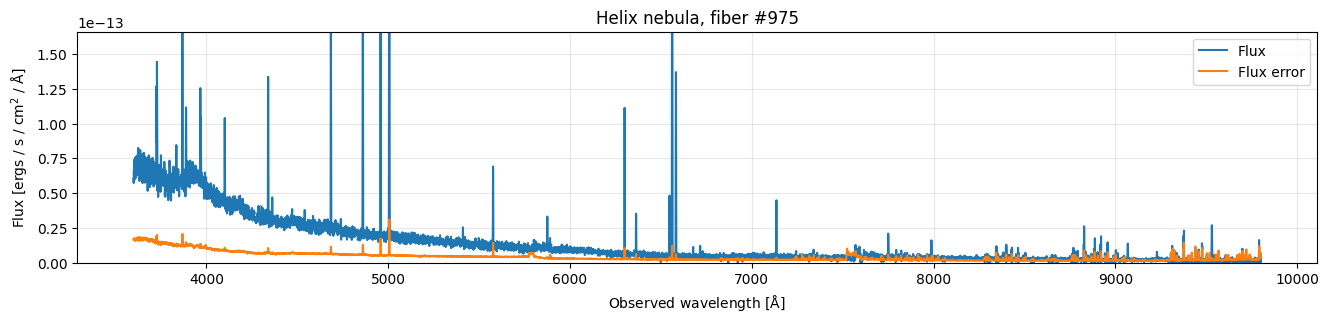

In [8]:
# Pick id of fiber of interest
# In this example we pick the central fiber
fiber = 975

# Call the function to obtain the flux index for the fiber of interest
flux_index = get_flux_index(fiber, df)

# Set plot parameters
fig, ax = plt.subplots(figsize=(16, 3))

# Plot
plt.plot(wave, flux[flux_index], label='Flux')
plt.plot(wave, error[flux_index], label='Flux error')
plt.title(f'Helix nebula, fiber #{fiber}')
plt.xlabel(r'Observed wavelength [${\rm \AA}$]')
plt.ylabel(r'Flux [ergs / s / cm$^2$ / ${\rm \AA}$]')
plt.ylim(0, max(flux[flux_index])/10)
plt.legend()
plt.grid(alpha=0.3)

# Zoom into spectral regions

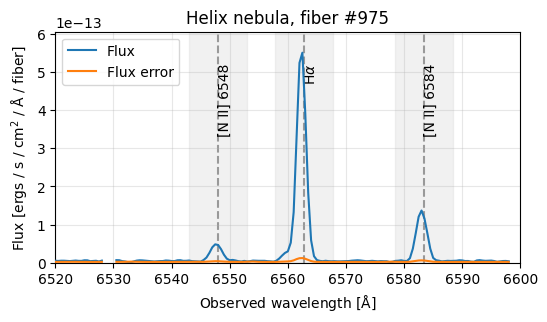

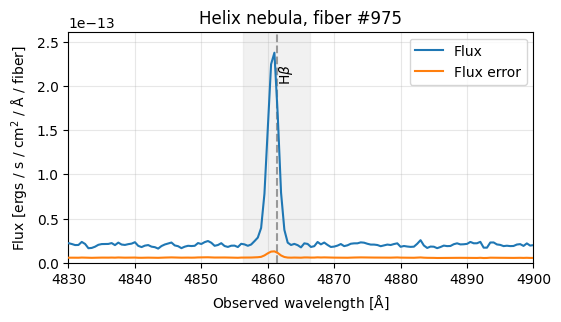

In [9]:
# Pick id of fiber of interest
fiber = 975

# Call the function to obtain the flux index for the fiber of interest
flux_index = get_flux_index(fiber, df)

# Load data of given fiber into variables
wavelengths = wave
flux_index = get_flux_index(fiber, df)
fib_fluxes = flux[flux_index]
fib_errors = error[flux_index]

# Create plot for region centered on Halpha + [N II]
# NOTE: the gap at ~6530 Ang is due to a bad column
minwave, maxwave = 6520, 6600
emission_lines = {
    '[N II] 6548': 6548.04,
    r'H$\alpha$': 6562.80,
    '[N II] 6584': 6583.46,
}

plot_single_fiber_sp_win(wavelengths, fib_fluxes, fib_errors, minwave, maxwave, emission_lines)

# Create plot for region centered on Hbeta
minwave, maxwave = 4830, 4900
emission_lines = {r'H$\beta$': 4861.325}
plot_single_fiber_sp_win(wavelengths, fib_fluxes, fib_errors, minwave, maxwave, emission_lines)

# Plot maps of spectral windows capturing single emission lines

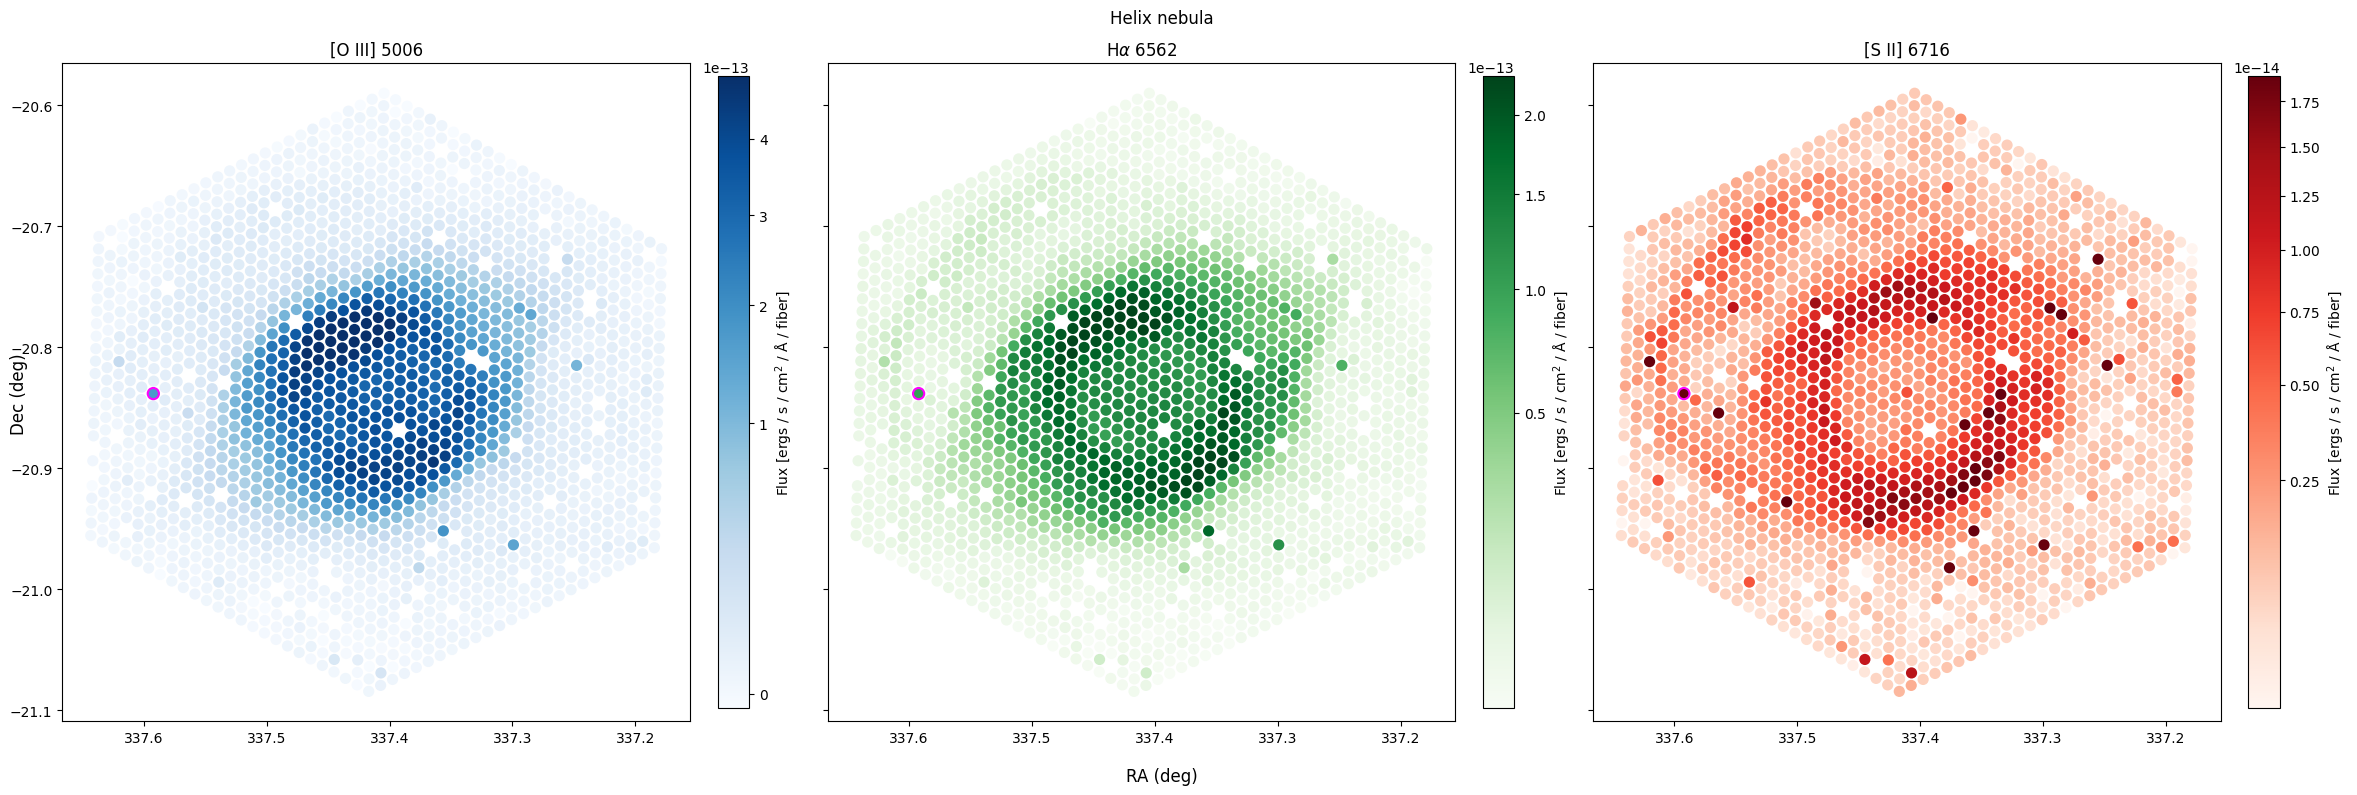

In [10]:
# Load fiber coordinates into variables
x = df['ra']
y = df['dec']

# Select some interesting lines
#lines = {"OII": (3727, 10), "OIII": (5007, 5), "Halpha": (6563, 10)}
lines = {
    "[O III]": (5006.843, 5), 
    r"H$\alpha$": (6562.80, 5), 
    "[S II]": (6716.44, 5) #[S II] doublet wavelengths are 6716.44, 6730.82. The first line is more luminous.
}

# Call the function to create the emission-line maps
lvm_emission_line_map(lines)

# Make an RGB image

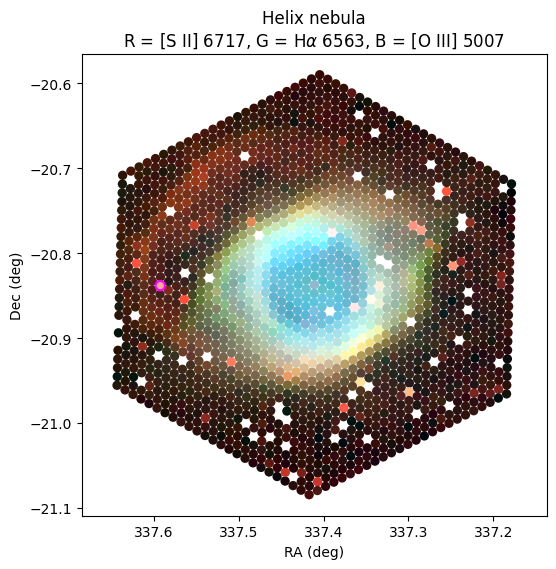

In [11]:
 lines = {
    "[O III]": (5006.843, 5), 
    r"H$\alpha$": (6562.80, 5), 
    "[S II]": (6716.44, 5) #Doublet wavelengths 6716.44, 6730.82, only take the first
}

# Create the rgb map
rgb_map(lines)

# Plot Gaussian fit to Balmer lines

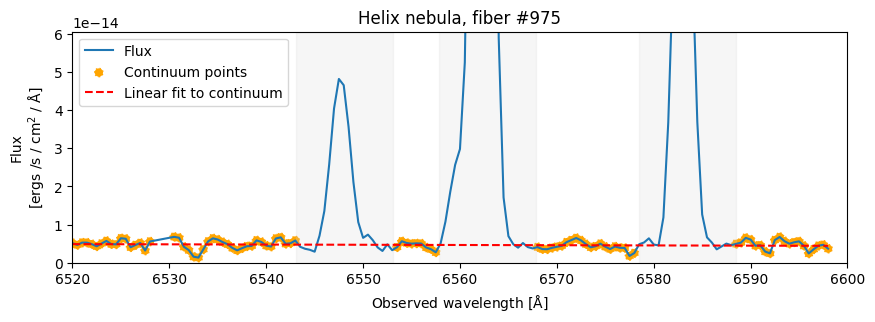

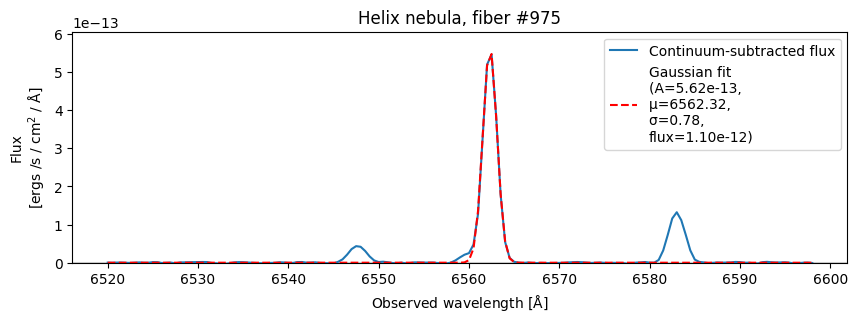

In [12]:
fiber=975
dx=5

# For a given fiber, get wavelengths and fluxes
wavelengths = wave
flux_index = get_flux_index(fiber, df)
fib_fluxes = flux[flux_index]

# Remove nan values from flux array
not_nan_indices = np.where(~np.isnan(fib_fluxes))[0]
wavelengths = wavelengths[not_nan_indices]
fib_fluxes = fib_fluxes[not_nan_indices]

# Extract wavelength range of interest

#minwave, maxwave, x0 = 4830, 4900, 4861.325 # Hb
minwave, maxwave, x0 = 6520, 6600, 6562.80 # Ha

# Define spectral line regions to exclude

#exclude_regions = [(4861.325-dx, 4861.325+dx)]  # Hb
exclude_regions = [(6548.04-dx, 6548.04+dx),(6562.80-dx, 6562.80+dx),(6583.46-dx, 6583.46+dx)]  # Ha and [N II] doublet

# Load mask data into variables
mask = (wavelengths >= minwave) & (wavelengths <= maxwave)
wavelengths = wavelengths[mask]
fib_fluxes = fib_fluxes[mask]

# Find peak of tallest line
ymax = max(fib_fluxes)

# Start with all data included
mask = np.ones_like(wavelengths, dtype=bool)

# Exclude each line region
for start, end in exclude_regions:
    mask &= ~((wavelengths >= start) & (wavelengths <= end))

# Apply mask
wavelengths_continuum = wavelengths[mask]
fluxes_continuum = fib_fluxes[mask]

# Set figure size
fig, ax = plt.subplots(figsize = (10, 3))

plt.xlabel(r'Observed wavelength [${\rm \AA}$]')
plt.ylabel('Flux\n'+r'[ergs /s / cm$^2$ / ${\rm \AA}$]')
plt.title(f"Helix nebula, fiber #{fiber}")

# Axis ranges
plt.xlim(minwave, maxwave)
plt.ylim(0, 1.1*max(fib_fluxes)/10)

# Plot the result prior to removing the continuum
plt.plot(wavelengths, fib_fluxes, label='Flux')
plt.scatter(wavelengths_continuum, fluxes_continuum, label='Continuum points', color='orange', linestyle=':')

# Shade regions of interest
for start, end in exclude_regions:
    plt.axvspan(start, end, color='lightgray', alpha=0.2)

#Fit a linear model to the continuum
fit_coeffs = np.polyfit(wavelengths_continuum, fluxes_continuum, deg=1)
fit_line = np.polyval(fit_coeffs, wavelengths)
plt.plot(wavelengths, fit_line, '--', label='Linear fit to continuum', color='red')
plt.legend()
plt.show()

# Remove continuum
cont_sub_flux = fib_fluxes - fit_line

# Plot the result with the removed continuum
fig, ax = plt.subplots(figsize = (10, 3))
# y-axis range
plt.ylim(0, 1.1*max(fib_fluxes))
plt.plot(wavelengths, cont_sub_flux, zorder=10, label='Continuum-subtracted flux')
plt.xlabel(r'Observed wavelength [${\rm \AA}$]')
plt.ylabel('Flux\n'+r'[ergs /s / cm$^2$ / ${\rm \AA}$]')
plt.axhline(y=0, color='lightgray', zorder=0)

# Initial parameter guess: (amplitude, mean, sigma)
p0 = [max(cont_sub_flux), x0, 1]

# Fit the curve
params, _ = curve_fit(gaussian, wavelengths, cont_sub_flux, p0=p0)

# Evaluate fitted Gaussian
fit_y = gaussian(wavelengths, *params)

# Plot result
plt.plot(wavelengths, 
         fit_y, 
         label=f'Gaussian fit\n(A={params[0]:.2e}, \nμ={params[1]:.2f}, \nσ={params[2]:.2f}, \nflux={np.sqrt(2*np.pi)*params[2]*params[0]:.2e})',
         color='red', zorder=11, linestyle='--')
plt.title(f"Helix nebula, fiber #{fiber}")
plt.legend()
plt.show()

# Make an emission line ratio map, e.g., H&alpha;/H&beta;
<span style="color:red">
The map is uncorrected for stellar absorption and background contamination<br>
Ratios lower than 2.8 are unphysical and shaded in either black or dark colors</span>

/Users/aidawofford/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


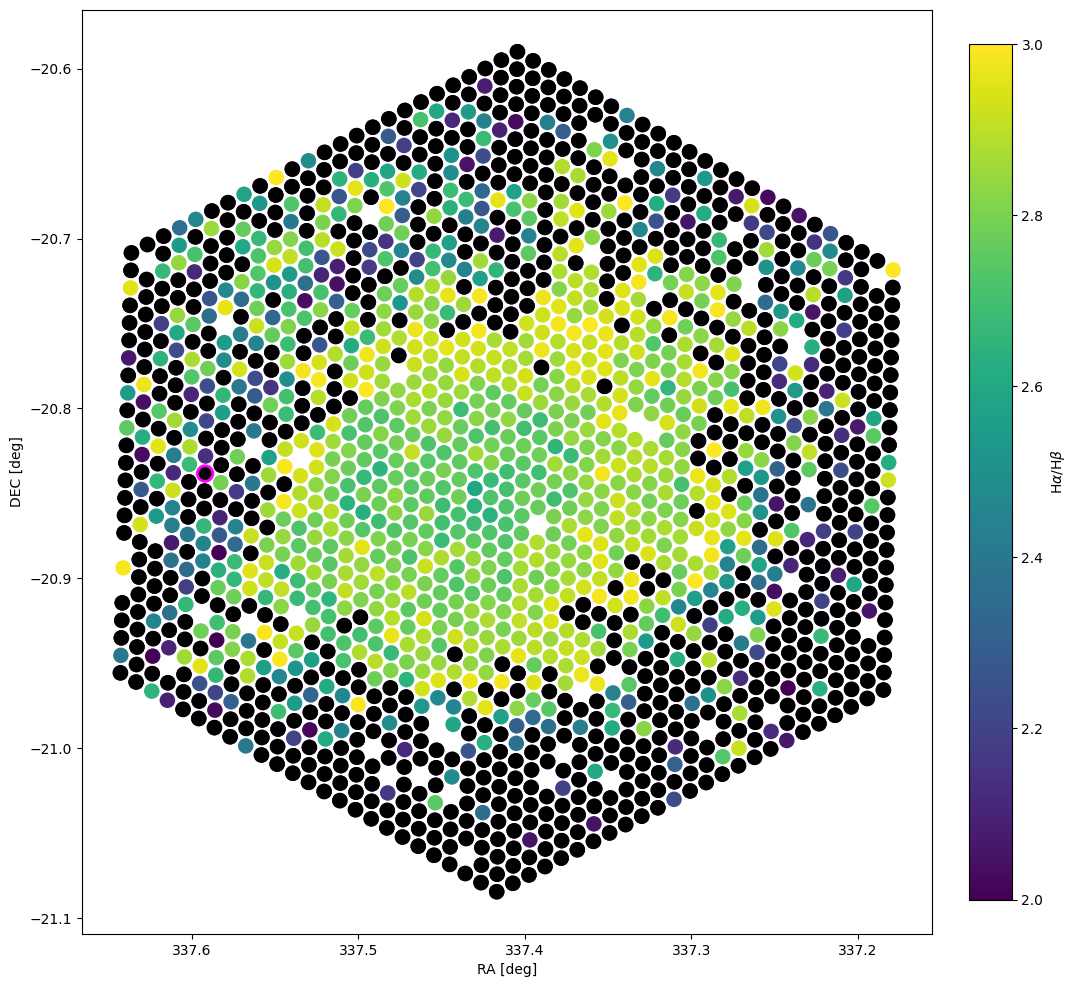

In [13]:
lvm_line_ratio_map(wave, flux, df)        